#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16783146665496171746
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9386132246033675665
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_kw.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(677, 16)
(677, 16)
(677, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'balance')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme', k = 7)
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme', k = 3)

dist_matrix:   0%|          | 0/134 [00:00<?, ?it/s]

r_index: 100%|##########| 38/38 [00:00<00:00, 575.62it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(543, 16)
(887, 16)
(986, 16)


In [14]:
As_smogn = As_smogn.reset_index(drop = True)
Cd_smogn = Cd_smogn.reset_index(drop = True)
Ni_smogn = Ni_smogn.reset_index(drop = True)

#### Eliminate outlier and train / test split

In [15]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [16]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [17]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [18]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [19]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(481, 15)
(813, 15)
(979, 15)


StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [21]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [22]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [23]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(384, 15)
(650, 15)
(783, 15)


#### 10-Fold Crossvalidation

In [24]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [25]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [26]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [27]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 02:04:19,228] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 02:04:20,103] Trial 0 finished with value: 0.4141736905346146 and parameters: {'n_estimators': 67, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.4141736905346146.
[I 2023-08-30 02:04:20,393] Trial 1 finished with value: 0.1048791680642708 and parameters: {'n_estimators': 46, 'max_depth': 1, 'min_samples_leaf': 18, 'min_samples_split': 17}. Best is trial 0 with value: 0.4141736905346146.
[I 2023-08-30 02:04:20,691] Trial 2 finished with value: 0.3015353663804679 and parameters: {'n_estimators': 30, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 14}. Best is trial 0 with value: 0.4141736905346146.
[I 2023-08-30 02:04:20,846] Trial 3 finished with value: 0.3176711099784667 and parameters: {'n_estimators': 14, 'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split': 15}. Best is trial 0 with value: 0.4141736905346146.
[I 2023

Best r2:  0.4518771795967188
Best trial: {'n_estimators': 63, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 63, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [30]:
study.best_trial.params["n_estimators"]

63

In [31]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=63, random_state=42)

In [32]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [33]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [34]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.33292434108283586
Test RMSE:  0.9047060026046333


In [35]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.8704857013537659
Test R2:  0.024875845660992768


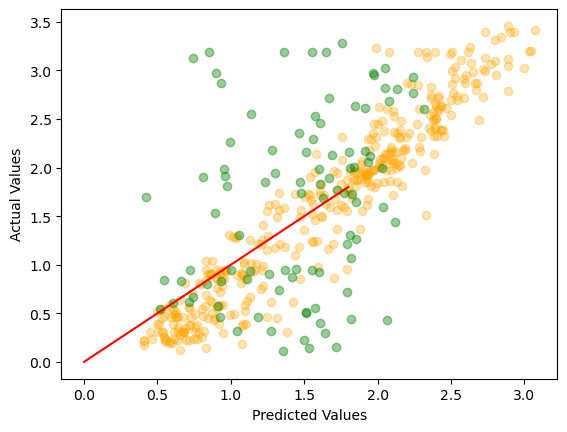

In [36]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [37]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 02:05:55,507] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 02:05:56,608] Trial 0 finished with value: 0.4709576687831234 and parameters: {'n_estimators': 73, 'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 12}. Best is trial 0 with value: 0.4709576687831234.
[I 2023-08-30 02:05:57,803] Trial 1 finished with value: 0.4723072830208734 and parameters: {'n_estimators': 80, 'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 15}. Best is trial 1 with value: 0.4723072830208734.
[I 2023-08-30 02:05:58,055] Trial 2 finished with value: 0.3156648706601389 and parameters: {'n_estimators': 25, 'max_depth': 2, 'min_samples_leaf': 19, 'min_samples_split': 10}. Best is trial 1 with value: 0.4723072830208734.
[I 2023-08-30 02:05:59,073] Trial 3 finished with value: 0.52578906502784 and parameters: {'n_estimators': 52, 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 14}. Best is trial 3 with value: 0.52578906502784.
[I 2023-08-

Best r2:  0.5815083630180411
Best trial: {'n_estimators': 90, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [38]:
optuna.visualization.plot_parallel_coordinate(study)

In [39]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 90, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


90

In [40]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=90,
                      random_state=42)

In [41]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [42]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.08714147460615691
Test RMSE:  0.23866772150229043


In [43]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9114474754102916
Test R2:  0.3481044025298856


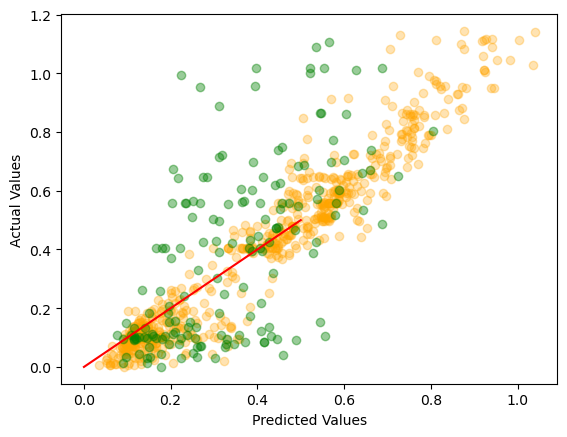

In [44]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [45]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-30 02:08:38,413] A new study created in memory with name: rf_parameter_opt
[I 2023-08-30 02:08:39,823] Trial 0 finished with value: 0.6504778005207249 and parameters: {'n_estimators': 48, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 13}. Best is trial 0 with value: 0.6504778005207249.
[I 2023-08-30 02:08:40,399] Trial 1 finished with value: 0.47846687536753424 and parameters: {'n_estimators': 38, 'max_depth': 4, 'min_samples_leaf': 13, 'min_samples_split': 15}. Best is trial 0 with value: 0.6504778005207249.
[I 2023-08-30 02:08:41,246] Trial 2 finished with value: 0.49199133037555975 and parameters: {'n_estimators': 53, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 0 with value: 0.6504778005207249.
[I 2023-08-30 02:08:42,204] Trial 3 finished with value: 0.4800400377508775 and parameters: {'n_estimators': 64, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 5}. Best is trial 0 with value: 0.6504778005207249.
[I 2023

Best r2:  0.6799452196576132
Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [46]:
optuna.visualization.plot_parallel_coordinate(study)

In [47]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}


97

In [48]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=97,
                      random_state=42)

In [49]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [50]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.351591433399287
Test RMSE:  0.9640608969874245


In [51]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9151128556707947
Test R2:  0.34252856412453625


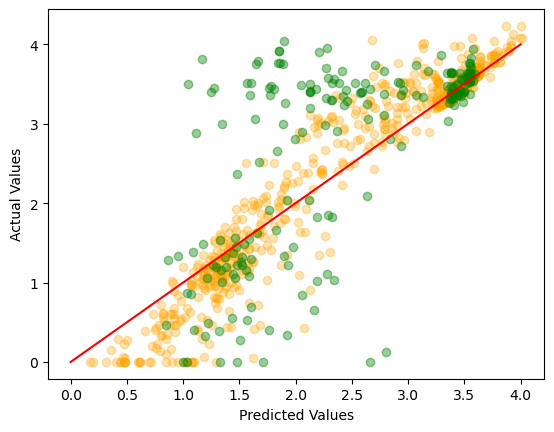

In [52]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()